##1. Configurações

In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#bibliotecas e módulos
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import tensorflow as tf
import time

from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception

In [3]:
#caminhos, constantes e parâmetros
#data
DATASET = 'Caltech256' #'Caltech101', 'Caltech256', 'octimine'

#image
CH = 3 #color channels
IM_HEIGHT = 224
IM_WIDTH = 224
INTERPOLATION = 'bilinear' #'bilinear', 'nearest', 'bicubic', 'area', 'lanczos3', 'lanczos5', 'gaussian' or 'mitchellcubic'

#
BATCH_SIZE = 32
SEED = 517

#algorithm
NEIGHBORS = 15

In [4]:
DATA_DIR = '/content/drive/My Drive/octimine/data/'
IM_DIR = '/content/drive/My Drive/octimine/' + DATASET


##2. Carregar Dados

In [5]:
#carregar imagens
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

dataset = tf.keras.utils.image_dataset_from_directory(
  IM_DIR,
  labels='inferred', #'inferred', None
  label_mode='categorical',  #'int', 'categorical', 'binary' or None
  class_names=None,
  color_mode='rgb',  #'grayscale', 'rgb' or 'rgba'
  batch_size=BATCH_SIZE,
  image_size=(IM_HEIGHT, IM_WIDTH),
  shuffle=False,
  seed=SEED,
  validation_split=None,
  subset=None,                #'training', 'validation' or 'both'
  interpolation=INTERPOLATION,
  follow_links=False,
  crop_to_aspect_ratio=False
)

Found 30607 files belonging to 257 classes.


In [6]:
#lista e grava o nome de todas as classes em um arquivo pickle
class_names = dataset.class_names
pickle.dump(
    class_names,
    open(DATA_DIR + DATASET + '-classes.pickle', 'wb'))

In [7]:
#lista e grava o endereço de todas as imagens em um arquivo pickle
path_list = dataset.file_paths
pickle.dump(
    path_list,
    open(DATA_DIR + DATASET + '-images.pickle', 'wb'))

In [8]:
#total de imagens no dataset
im_total = len(dataset.file_paths)
im_total

30607

In [9]:
#número de passos durante a extração de features
STEPS = int(math.ceil(im_total / BATCH_SIZE))
STEPS

957

##3. Manipular Dados

In [13]:
#configura dados para melhor desempenho
#https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance

AUTOTUNE = tf.data.AUTOTUNE
#tuned_dataset = rescaled_dataset.cache().prefetch(buffer_size=AUTOTUNE)
tuned_dataset = dataset.prefetch(buffer_size=AUTOTUNE)

##4. Modelo

In [10]:
#carrega modelo base pré-treinado
#https://keras.io/guides/transfer_learning/
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(IM_WIDTH, IM_HEIGHT, CH),
                  pooling='max')

94765736/94765736 [==============================] - 0s 0us/step


In [11]:
#congela modelo base pré-treinado
model.trainable = False

In [14]:
#extrai características (features)
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
#https://keras.io/api/models/model_training_apis/
#https://github.com/keras-team/keras/blob/v2.10.0/keras/engine/training.py#L2076
#link to solve the memory problem
#https://www.thekerneltrip.com/python/keras-memory-leak/

feature_list = []

feature_list = model.predict(
  tuned_dataset,
  batch_size=None,
  verbose='auto',
  steps=STEPS, #entender melhor influência desse atributo
  callbacks=None,
  max_queue_size=10,
  workers=1,
  use_multiprocessing=False
)

957/957 [==============================] - 10901s 11s/step


In [15]:
feature_list.shape

(30607, 2048)

In [16]:
#grava lista de características no disco
pickle.dump(
    feature_list,
    open(DATA_DIR + DATASET + '-features.pickle02', 'wb'))

##5. Busca

In [17]:
cl_list   = pickle.load(open(DATA_DIR + DATASET + '-classes.pickle', 'rb'))
path_list = pickle.load(open(DATA_DIR + DATASET + '-images.pickle', 'rb'))
feat_list = pickle.load(open(DATA_DIR + DATASET + '-features.pickle02', 'rb'))

In [18]:
#treina algoritmo KNN
#https://scikit-learn.org/stable/modules/neighbors.html
KNN = NearestNeighbors(n_neighbors=NEIGHBORS,
                       algorithm='brute',
                       metric='euclidean').fit(feat_list) 

(-0.5, 150.5, 167.5, -0.5)

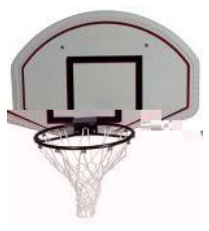

In [19]:
#query internal image
#find image index
#https://stackoverflow.com/questions/176918/finding-the-index-of-an-item-in-a-list

#im_path = 'Faces/image_0658.jpg'
#im_idx = path_list.index(IM_DIR + im_path)
im_idx = 660

#good: 1658, 4456, 12000, 17351
#bad: 658, 2456, 11456, 20000, 27501
#strange: 9000
#compare: 1904 with 1905

#lista distâncias entre a query image e as n imagens similares
#lista índices das n imagens similares
distances, indices = KNN.kneighbors([feat_list[im_idx]])

#print query image
plt.figure(figsize=(4, 4))
plt.imshow(mpimg.imread(path_list[im_idx]), interpolation=INTERPOLATION)
plt.axis("off")

1.2063132e-05 /content/drive/My Drive/octimine/Caltech256/006.basketball-hoop/006_0040.jpg 660
190.4352 /content/drive/My Drive/octimine/Caltech256/006.basketball-hoop/006_0073.jpg 693
195.12877 /content/drive/My Drive/octimine/Caltech256/006.basketball-hoop/006_0011.jpg 631
195.54556 /content/drive/My Drive/octimine/Caltech256/006.basketball-hoop/006_0055.jpg 675
197.81711 /content/drive/My Drive/octimine/Caltech256/006.basketball-hoop/006_0081.jpg 701
198.43614 /content/drive/My Drive/octimine/Caltech256/006.basketball-hoop/006_0024.jpg 644
199.19035 /content/drive/My Drive/octimine/Caltech256/096.hammock/096_0148.jpg 10475
199.20291 /content/drive/My Drive/octimine/Caltech256/107.hot-air-balloon/107_0005.jpg 11770
201.34857 /content/drive/My Drive/octimine/Caltech256/131.lightbulb/131_0033.jpg 14502
202.18582 /content/drive/My Drive/octimine/Caltech256/053.desk-globe/053_0056.jpg 5962
202.30687 /content/drive/My Drive/octimine/Caltech256/006.basketball-hoop/006_0041.jpg 661
202.5410

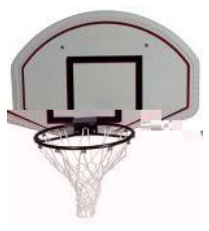

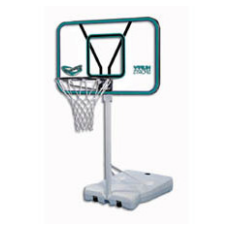

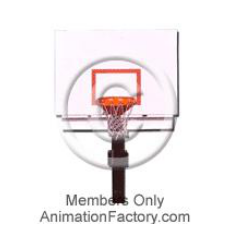

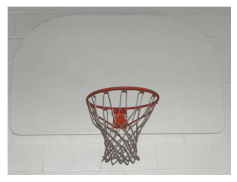

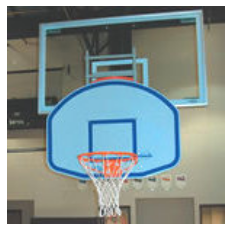

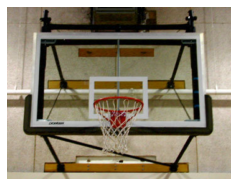

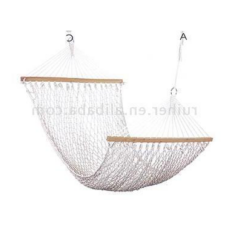

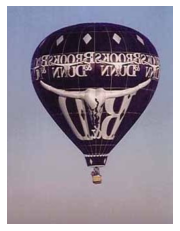

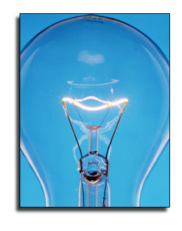

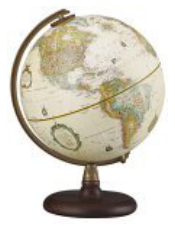

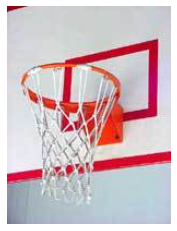

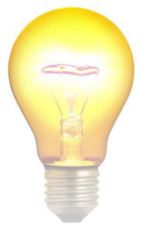

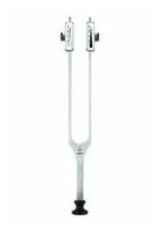

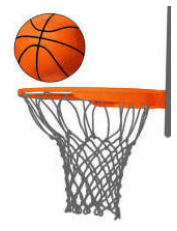

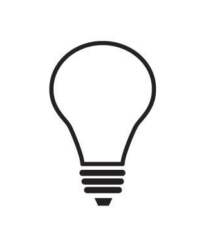

In [ ]:
for i in range(NEIGHBORS):
  print(distances[0][i], path_list[indices[0][i]], indices[0][i])
  plt.figure(figsize=(4, 4))
  plt.imshow(mpimg.imread(path_list[indices[0][i]]), interpolation=INTERPOLATION)
  plt.axis("off")